# Libraries

In [207]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import numpy as np
import os
from textblob import TextBlob

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1485341, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

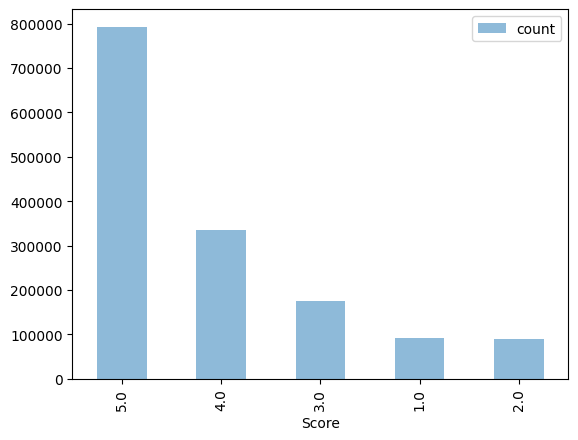


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [208]:
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")
trainingSet = trainingSet.dropna(subset=['Score'])

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [209]:
product_avg_score = trainingSet.groupby('ProductId')['Score'].mean().to_dict()
user_avg_score = trainingSet.groupby('UserId')['Score'].mean().to_dict()

def add_features_to(df, product_avg_score_dict, user_avg_score_dict):
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] > 0,
                                     df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],
                                     0)
    else:
        df['Helpfulness'] = 0

    if 'Time' in df.columns:
        current_date = pd.Timestamp.now()
        df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
        df['ReviewAge'] = (current_date - df['Time']).dt.days
    else:
        df['ReviewAge'] = 0

    if 'Text' in df.columns:
        df['SentimentPolarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else 0)
    else:
        df['SentimentPolarity'] = 0

    if 'ProductId' in df.columns:
        df['AverageProductScore'] = df['ProductId'].map(product_avg_score_dict)
        df['AverageProductScore'] = df['AverageProductScore'].fillna(trainingSet['Score'].mean())
    else:
        df['AverageProductScore'] = trainingSet['Score'].mean()

    if 'UserId' in df.columns:
        df['AverageUserScore'] = df['UserId'].map(user_avg_score_dict)
        df['AverageUserScore'] = df['AverageUserScore'].fillna(trainingSet['Score'].mean())
    else:
        df['AverageUserScore'] = trainingSet['Score'].mean()

    return df

def preprocess_data(df, product_avg_score_dict, user_avg_score_dict, oe_product=None, oe_user=None):
    df = add_features_to(df, product_avg_score_dict, user_avg_score_dict)

    if 'ProductId' in df.columns:
        df['ProductId'] = df['ProductId'].astype(str)
    else:
        df['ProductId'] = '-1'

    if 'UserId' in df.columns:
        df['UserId'] = df['UserId'].astype(str)
    else:
        df['UserId'] = '-1'

    if oe_product is None:
        oe_product = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    if not hasattr(oe_product, 'categories_'):
        oe_product.fit(df[['ProductId']])
    df[['ProductId']] = oe_product.transform(df[['ProductId']])

    if oe_user is None:
        oe_user = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    if not hasattr(oe_user, 'categories_'):
        oe_user.fit(df[['UserId']])
    df[['UserId']] = oe_user.transform(df[['UserId']])

    numerical_cols = ['Helpfulness', 'ReviewAge', 'SentimentPolarity', 'AverageProductScore', 'AverageUserScore']

    existing_numerical_cols = [col for col in numerical_cols if col in df.columns]
    if existing_numerical_cols:
        scaler = StandardScaler()
        df[existing_numerical_cols] = scaler.fit_transform(df[existing_numerical_cols])

    return df, oe_product, oe_user

X_train_preprocessed, oe_product, oe_user = preprocess_data(trainingSet, product_avg_score, user_avg_score)

X_test_preprocessed, _, _ = preprocess_data(testingSet, product_avg_score, user_avg_score, oe_product, oe_user)

# Sample + Split into training and testing set

In [210]:
X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(
    X_train_preprocessed,
    trainingSet['Score'],
    test_size=0.25,
    random_state=0
)

# Feature Selection

In [214]:
features = ['Helpfulness', 'ReviewAge', 'SentimentPolarity', 'AverageProductScore', 'AverageUserScore', 'ProductId', 'UserId']

X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(
    X_train_preprocessed,
    trainingSet['Score'],
    test_size=0.25,
    random_state=0
)

valid_indices_train = Y_train_data.notnull() & ~np.isinf(Y_train_data)

X_train_data_clean = X_train_data[valid_indices_train]
Y_train_data_clean = Y_train_data[valid_indices_train]

valid_indices_test = Y_test_data.notnull() & ~np.isinf(Y_test_data)
X_test_data_clean = X_test_data[valid_indices_test]
Y_test_data_clean = Y_test_data[valid_indices_test]

X_train_select = X_train_data_clean[features]
X_test_select = X_test_data_clean[features]
X_submission_select = X_test_preprocessed[features]

Y_train = Y_train_data_clean.astype(int) - 1
Y_test = Y_test_data_clean.astype(int) - 1

# Model Creation

In [215]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    random_state=42,
    learning_rate=0.1,
    max_depth=6,
    subsample=1,
    colsample_bytree=1,
    n_estimators=100
)

model.fit(X_train_select, Y_train)
print("Model trained.")

Y_test_predictions = model.predict(X_test_select)

Y_test_predictions = Y_test_predictions + 1
Y_test_actual = Y_test + 1

Model trained.


# Model Evaluation

Validation Accuracy: 0.6124776482754163


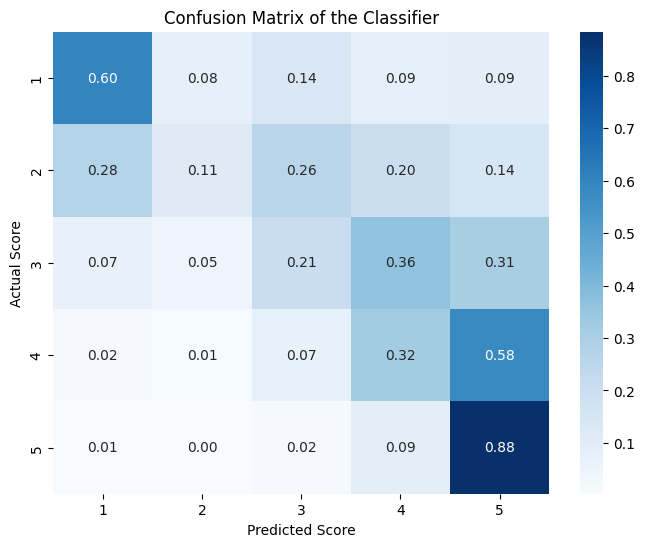

In [216]:
accuracy = accuracy_score(Y_test_actual, Y_test_predictions)
print(f"Validation Accuracy: {accuracy}")

cm = confusion_matrix(Y_test_actual, Y_test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,6), yticklabels=range(1,6))
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')
plt.show()

# Create submission file

In [217]:
Y_submission_pred = model.predict(X_submission_select) + 1

submission = pd.DataFrame({
    'Id': testingSet['Id'],
    'Score': Y_submission_pred.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

Submission file created successfully!
